<a href="https://colab.research.google.com/github/CiaraFarrellSETU/phd/blob/main/fullmap_rf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
from google.colab import widgets
import os
import numpy as np
import geopandas as gpd
import rasterio
from shapely.geometry import Point
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
zip_path = input("Please paste the path to your zip file from the sidebar: ")
destination = "/content/dataset"

if os.path.exists(zip_path):
    !unzip -q "{zip_path}" -d "{destination}"
    print(f"Successfully unzipped to {destination}")
else:
    print("Error: File path not found. Did you mount your drive?")
drive.mount('/content/drive')

Please paste the path to your zip file from the sidebar: /content/drive/MyDrive/scraghbog.zip
Successfully unzipped to /content/dataset
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
S_RGB_PATH = input("Summer RGB Path: ")
S_NDVI_PATH = input("Summer NDVI Path: ")
S_DSM = input("Summer DSM Path: ")
W_RGB_PATH = input("Winter RGB Path: ")
W_NDVI_PATH = input("Winter NDVI Path: ")
W_DSM = input("Winter DSM Path: ")
SHP_PATH = input("Shapefile (.shp) Path: ")

Summer RGB Path: /content/dataset/scraghbog/scraghbog_rgb_summer.tif
Summer NDVI Path: /content/dataset/scraghbog/Scraghbog_Summer_NDVI.tif
Summer DSM Path: /content/dataset/scraghbog/scraghbog_dem_summer.tif
Winter RGB Path: /content/dataset/scraghbog/Scraghbog_RGB_winter.tif
Winter NDVI Path: /content/dataset/scraghbog/Scraghbog_Winter_NDVI.tif
Winter DSM Path: /content/dataset/scraghbog/Scraghbog_Winter_DSM.tif
Shapefile (.shp) Path: /content/dataset/scraghbog/scraghBog_habiMap.shp


In [7]:
LABEL_COL = 'fid'
NAME_COL = 'HCH_MAPPED'

gdf = gpd.read_file(SHP_PATH)


In [8]:
fossitt_merger = {
    'GS4': 'Grassland',
    'PF1' : 'fen', 'PF3': 'fen',
    'WD4': 'Tree & scrub', 'WN6': 'Tree & scrub', 'WN7': 'Tree & scrub',
    'FS1': 'Swamp/water', 'FS2': 'Swamp/water', 'FW2/WL2': 'Swamp/water'

}
gdf['merged_name'] = gdf[NAME_COL].replace(fossitt_merger)

In [9]:
def calculate_local_slope(window, res=1.0):
    if window.shape != (3, 3): return 0.0
    dz_dx = ((window[0,2] + 2*window[1,2] + window[2,2]) - (window[0,0] + 2*window[1,0] + window[2,0])) / (8 * res)
    dz_dy = ((window[2,0] + 2*window[2,1] + window[2,2]) - (window[0,0] + 2*window[0,1] + window[0,2])) / (8 * res)
    return np.degrees(np.arctan(np.sqrt(dz_dx**2 + dz_dy**2)))

In [10]:
def calc_indices(r, g, b, nir):
    eps = 1e-5
    rvi = nir / (r + eps)
    savi = ((nir - r) / (nir + r + 0.5 + eps)) * 1.5
    evi = 2.5 * ((nir - r) / (nir + 6 * r - 7.5 * b + 1 + eps))
    gndvi = (nir - g) / (nir + g + eps)
    grvi = (g - r) / (g + r + eps)
    nrvi = (rvi - 1) / (rvi + 1 + eps)
    ndwi = (g - nir) / (g + nir + eps)
    vari = (g - r) / (g + r - b + eps)
    return np.column_stack([rvi, savi, evi, gndvi, grvi, nrvi, ndwi, vari])

In [11]:
all_pixels, all_labels = [], []

with rasterio.open(S_RGB_PATH) as sr, rasterio.open(S_NDVI_PATH) as sn, \
     rasterio.open(S_DSM) as sd, rasterio.open(W_RGB_PATH) as wr, \
     rasterio.open(W_NDVI_PATH) as wn, rasterio.open(W_DSM) as wd:

    RES = sd.res[0]
    gdf = gpd.read_file(SHP_PATH).to_crs(sr.crs)
    gdf['merged_name'] = gdf['HCH_MAPPED'].replace(fossitt_merger)

    print("Step 1: Extracting 32 features using proportional sampling...")
    for idx, row in gdf.iterrows():
        poly = row.geometry
        area = poly.area
        # Proportional logic: 1 point per 100sq units, clamped between 500 and 10,000
        num_samples = max(500, min(int(area / 100), 10000))

        pts = []
        for _ in range(num_samples * 3):
            min_x, min_y, max_x, max_y = poly.bounds
            pt = (np.random.uniform(min_x, max_x), np.random.uniform(min_y, max_y))
            if Point(pt).within(poly): pts.append(pt)
            if len(pts) >= num_samples: break

        if not pts: continue

        # Sample base data
        s_rgb = np.array(list(sr.sample(pts))).astype('float32')
        w_rgb = np.array(list(wr.sample(pts))).astype('float32')
        s_nd = np.array(list(sn.sample(pts))).astype('float32').flatten()
        w_nd = np.array(list(wn.sample(pts))).astype('float32').flatten()
        s_h = np.array(list(sd.sample(pts))).astype('float32').flatten()
        w_h = np.array(list(wd.sample(pts))).astype('float32').flatten()

        # Reverse-engineer NIR from Red and NDVI
        s_nir = s_rgb[:, 0] * (1 + np.clip(s_nd, -0.99, 0.99)) / (1 - np.clip(s_nd, -0.99, 0.99) + 1e-5)
        w_nir = w_rgb[:, 0] * (1 + np.clip(w_nd, -0.99, 0.99)) / (1 - np.clip(w_nd, -0.99, 0.99) + 1e-5)

        s_idx = calc_indices(s_rgb[:,0], s_rgb[:,1], s_rgb[:,2], s_nir)
        w_idx = calc_indices(w_rgb[:,0], w_rgb[:,1], w_rgb[:,2], w_nir)

        # Assemble the 32 Features
        combined = np.column_stack([
            s_rgb, w_rgb, s_nd, w_nd, s_h, w_h, s_nir, w_nir,
            s_idx, w_idx,
            np.zeros_like(s_nd), np.zeros_like(s_nd), # Placeholder for slope
            (s_nd - w_nd), (s_h - w_h)
        ])

        valid_mask = np.any(s_rgb > 0, axis=1)
        if np.any(valid_mask):
            all_pixels.append(combined[valid_mask])
            all_labels.extend([row['merged_name']] * np.sum(valid_mask))

Step 1: Extracting 32 features using proportional sampling...


In [12]:
X = np.nan_to_num(np.vstack(all_pixels), nan=0, posinf=0, neginf=0)
y = np.array(all_labels)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
rf = RandomForestClassifier(n_estimators=700, class_weight='balanced', n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=700, n_jobs=-1,
                       random_state=42)

In [14]:
print("\n--- Training Report ---")
print(classification_report(y_test, rf.predict(X_test)))


--- Training Report ---
              precision    recall  f1-score   support

   Grassland       0.70      0.86      0.77       231
 Swamp/water       0.77      0.69      0.73       560
Tree & scrub       0.94      0.91      0.93       693
         fen       0.81      0.85      0.83       646

    accuracy                           0.83      2130
   macro avg       0.80      0.83      0.81      2130
weighted avg       0.83      0.83      0.83      2130



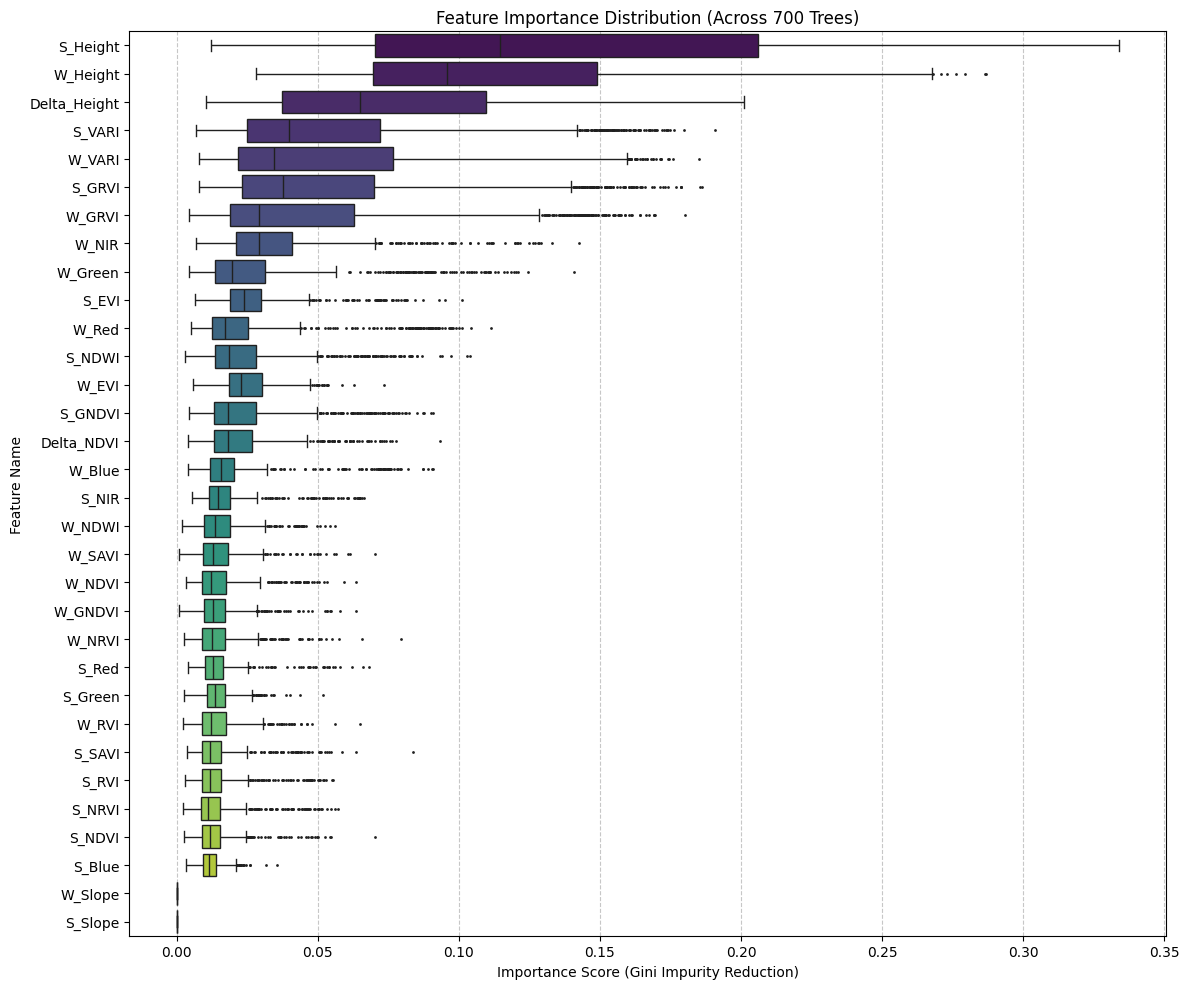

In [15]:
import pandas as pd

# 1. Define the 32 feature names in the exact order they were stacked
feature_names = [
    'S_Red', 'S_Green', 'S_Blue',
    'W_Red', 'W_Green', 'W_Blue',
    'S_NDVI', 'W_NDVI',
    'S_Height', 'W_Height',
    'S_NIR', 'W_NIR',
    'S_RVI', 'S_SAVI', 'S_EVI', 'S_GNDVI', 'S_GRVI', 'S_NRVI', 'S_NDWI', 'S_VARI',
    'W_RVI', 'W_SAVI', 'W_EVI', 'W_GNDVI', 'W_GRVI', 'W_NRVI', 'W_NDWI', 'W_VARI',
    'S_Slope', 'W_Slope',
    'Delta_NDVI', 'Delta_Height'
]

# 2. Extract importance from all 700 trees to show distribution
# This is the closest representation to a "Box Plot" for RF importance
importances = [tree.feature_importances_ for tree in rf.estimators_]
df_importance = pd.DataFrame(importances, columns=feature_names)

# 3. Sort by mean importance
sorted_indices = df_importance.mean().sort_values(ascending=False).index
df_sorted = df_importance[sorted_indices]

# 4. Plotting
plt.figure(figsize=(12, 10))
sns.boxplot(data=df_sorted, orient='h', palette='viridis', fliersize=1)
plt.title('Feature Importance Distribution (Across 700 Trees)')
plt.xlabel('Importance Score (Gini Impurity Reduction)')
plt.ylabel('Feature Name')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [20]:
import numpy as np
import rasterio
from rasterio.enums import Resampling
import warnings

# 1. Setup and Mappings
warnings.filterwarnings('ignore', category=RuntimeWarning)
target_res = 0.5  # 50cm resolution
output_path = "/content/drive/MyDrive/Habitat_Map_0.5m_Doyle_Method.tif"

# Define your legend based on your training labels
unique_labels = sorted(np.unique(y).tolist())
label_to_int = {name: i+1 for i, name in enumerate(unique_labels)}

print(f"Class Mapping: {label_to_int}")

# 2. Calculate New Dimensions for 0.5m Resolution
with rasterio.open(S_RGB_PATH) as src:
    scale_factor = src.res[0] / target_res
    new_height = int(src.height * scale_factor)
    new_width = int(src.width * scale_factor)

    new_transform = src.transform * src.transform.scale(
        (src.width / new_width), (src.height / new_height)
    )

    meta = src.meta.copy()
    meta.update({
        'height': new_height, 'width': new_width,
        'transform': new_transform, 'dtype': 'uint8',
        'count': 1, 'nodata': 0, 'compress': 'lzw'
    })

# 3. Resample and Process
with rasterio.open(S_RGB_PATH) as sr, rasterio.open(S_NDVI_PATH) as sn, \
     rasterio.open(S_DSM) as sd, rasterio.open(W_RGB_PATH) as wr, \
     rasterio.open(W_NDVI_PATH) as wn, rasterio.open(W_DSM) as wd, \
     rasterio.open(output_path, 'w', **meta) as dst:

    def read_safe(ds, count=1):
        """Resamples and aligns any layer to the 0.5m master grid."""
        return ds.read(
            range(1, count + 1) if count > 1 else 1,
            out_shape=(count, new_height, new_width) if count > 1 else (new_height, new_width),
            resampling=Resampling.bilinear,
            boundless=True, fill_value=0
        )

    print("Step 1: Resampling all layers to 0.5m...")
    s_rgb = read_safe(sr, 3).transpose(1, 2, 0).reshape(-1, 3).astype('float32')
    w_rgb = read_safe(wr, 3).transpose(1, 2, 0).reshape(-1, 3).astype('float32')
    s_nd = read_safe(sn).flatten().astype('float32')
    w_nd = read_safe(wn).flatten().astype('float32')
    s_h = read_safe(sd).flatten().astype('float32')
    w_h = read_safe(wd).flatten().astype('float32')

    print("Step 2: Calculating Multi-temporal Indices...")
    with np.errstate(divide='ignore', invalid='ignore'):
        # NIR back-calculation (critical for Doyle indices)
        s_nd_c = np.clip(s_nd, -0.99, 0.99)
        w_nd_c = np.clip(w_nd, -0.99, 0.99)
        s_nir = s_rgb[:, 0] * (1 + s_nd_c) / (1 - s_nd_c + 1e-5)
        w_nir = w_rgb[:, 0] * (1 + w_nd_c) / (1 - w_nd_c + 1e-5)

        # Spectral Indices (S_VARI, W_NDWI, etc.)
        s_idx = calc_indices(s_rgb[:,0], s_rgb[:,1], s_rgb[:,2], s_nir)
        w_idx = calc_indices(w_rgb[:,0], w_rgb[:,1], w_rgb[:,2], w_nir)

        # Build 32-feature stack
        X_all = np.column_stack([
            s_rgb, w_rgb, s_nd, w_nd, s_h, w_h, s_nir, w_nir,
            s_idx, w_idx,
            np.zeros_like(s_nd), np.zeros_like(s_nd), # Slope
            (s_nd - w_nd), (s_h - w_h) # Deltas
        ])
        X_all = np.nan_to_num(X_all, nan=0.0)

    print("Step 3: Running Random Forest Classification...")
    # rf is your model trained with n_estimators=1000 and balanced weights
    preds = rf.predict(X_all)

    # Reshape and Write
    final_map = np.array([label_to_int[p] for p in preds]).reshape((new_height, new_width))
    dst.write(final_map.astype('uint8'), 1)

print(f"Classification Complete! Final map saved: {output_path}")

Class Mapping: {'Grassland': 1, 'Swamp/water': 2, 'Tree & scrub': 3, 'fen': 4}
Step 1: Resampling all layers to 0.5m...
Step 2: Calculating Multi-temporal Indices...
Step 3: Running Random Forest Classification...
Classification Complete! Final map saved: /content/drive/MyDrive/Habitat_Map_0.5m_Doyle_Method.tif


In [21]:
from sklearn.metrics import accuracy_score, cohen_kappa_score

# 1. Predict on the test set (the 30% we held back earlier)
y_pred_test = rf.predict(X_test)

# 2. Calculate Overall Accuracy
oa = accuracy_score(y_test, y_pred_test)

# 3. Calculate Kappa (Adjusts for chance agreement)
kappa = cohen_kappa_score(y_test, y_pred_test)

print(f"Overall Accuracy: {oa:.2%}")
print(f"Kappa Coefficient: {kappa:.3f}")

Overall Accuracy: 82.63%
Kappa Coefficient: 0.760


In [22]:
rf = RandomForestClassifier(n_estimators=700,
                            class_weight='balanced',
                            n_jobs=-1,
                            random_state=42,
                            oob_score=True) # Add this
rf.fit(X_train, y_train)

print(f"Out-of-Bag Accuracy: {rf.oob_score_:.2%}")

Out-of-Bag Accuracy: 81.72%


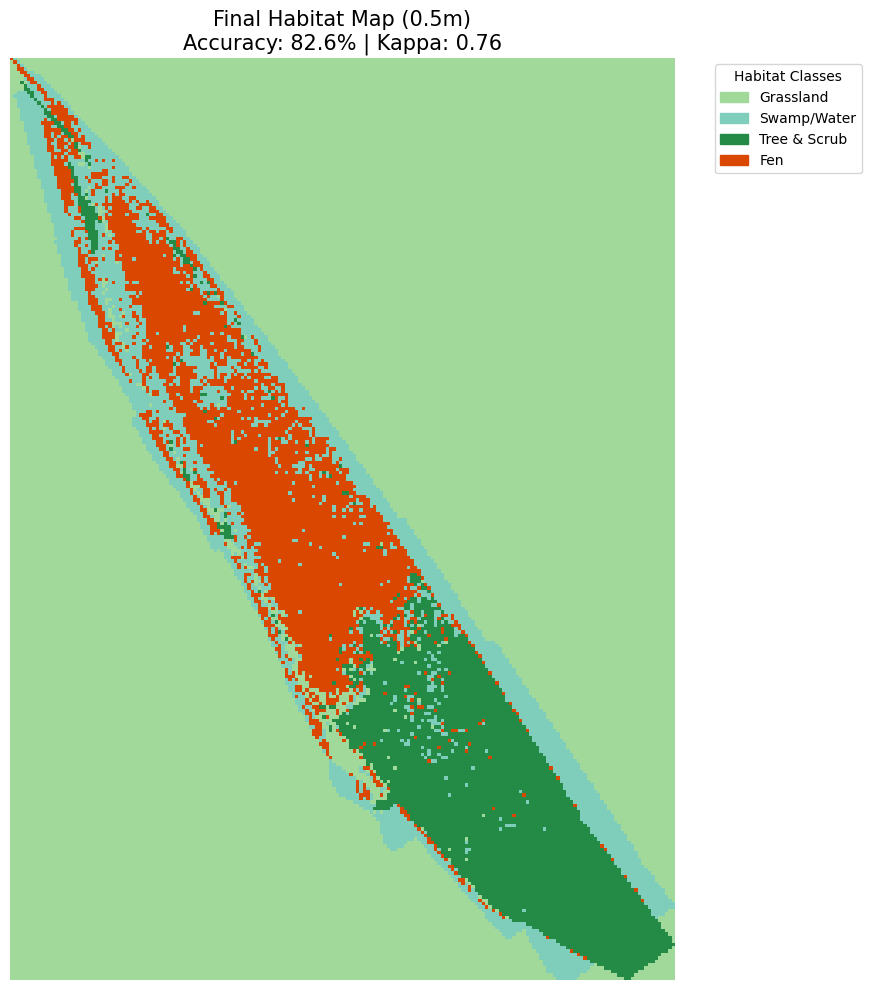

In [25]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import rasterio

# 1. Open and read a downsampled version for the preview
with rasterio.open(output_path) as src:
    # Reading every 10th pixel for a fast, memory-safe preview
    preview_data = src.read(1, out_shape=(src.height // 10, src.width // 10))

# 2. Define a professional color palette
# 0: NoData (White), 1: Grassland (Light Green), 2: Swamp (Cyan),
# 3: Tree & Scrub (Forest Green), 4: Fen (Brown/Orange)
habitat_colors = ['#FFFFFF', '#A1D99B', '#7FCDBB', '#238B45', '#D94701']
cmap = ListedColormap(habitat_colors)

# 3. Plotting
fig, ax = plt.subplots(figsize=(14, 10))
im = ax.imshow(preview_data, cmap=cmap, vmin=0, vmax=4)

# Create Legend handles
legend_dict = {
    'Grassland': '#A1D99B',
    'Swamp/Water': '#7FCDBB',
    'Tree & Scrub': '#238B45',
    'Fen': '#D94701'
}
patches = [mpatches.Patch(color=color, label=label) for label, color in legend_dict.items()]

ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', title="Habitat Classes")
plt.title(f"Final Habitat Map (0.5m)\nAccuracy: 82.6% | Kappa: 0.76", fontsize=15)
plt.axis('off')
plt.tight_layout()
plt.show()

In [31]:
import numpy as np
import rasterio
from rasterio.enums import Resampling
from rasterio.features import rasterize
import warnings

warnings.filterwarnings('ignore', category=RuntimeWarning)
target_res = 0.5
output_path = "/content/drive/MyDrive/Habitat_Map_0.5m_Doyle_Masked.tif"

# Legened mapping
unique_labels = sorted(np.unique(y).tolist())
label_to_int = {name: i+1 for i, name in enumerate(unique_labels)}

with rasterio.open(S_RGB_PATH) as src:
    scale_factor = src.res[0] / target_res
    new_height, new_width = int(src.height * scale_factor), int(src.width * scale_factor)
    new_transform = src.transform * src.transform.scale((src.width / new_width), (src.height / new_height))

    meta = src.meta.copy()
    meta.update({
        'height': new_height, 'width': new_width,
        'transform': new_transform, 'dtype': 'uint8',
        'count': 1, 'nodata': 0, # 0 will now be invisible/background
        'compress': 'lzw'
    })

with rasterio.open(S_RGB_PATH) as sr, rasterio.open(S_NDVI_PATH) as sn, \
     rasterio.open(S_DSM) as sd, rasterio.open(W_RGB_PATH) as wr, \
     rasterio.open(W_NDVI_PATH) as wn, rasterio.open(W_DSM) as wd, \
     rasterio.open(output_path, 'w', **meta) as dst:

    def read_res(ds, count=1):
        return ds.read(range(1, count + 1) if count > 1 else 1,
                       out_shape=(count, new_height, new_width) if count > 1 else (new_height, new_width),
                       resampling=Resampling.bilinear, boundless=True, fill_value=0)

    print("Reading and Masking...")
    # s_rgb_raw = read_res(sr, 3)

    # --- NEW MASKING LOGIC ---
    # Re-read gdf to ensure its CRS is aligned with the raster for proper masking
    gdf_reprojected = gpd.read_file(SHP_PATH).to_crs(sr.crs)
    # Create a single geometry from the union of all polygons in gdf
    all_polygons_union = gdf_reprojected.geometry.unary_union
    # Rasterize the union of polygons to create a mask with 1s inside, 0s outside
    mask_from_shp = rasterize([all_polygons_union], out_shape=(new_height, new_width), transform=new_transform, fill=0, all_touched=True, dtype='uint8')
    # Convert to boolean mask for indexing: True for valid data (within shapefile), False for outside
    mask = mask_from_shp.astype(bool)
    # ------------------------

    s_rgb = read_res(sr, 3).transpose(1, 2, 0).reshape(-1, 3).astype('float32')
    w_rgb = read_res(wr, 3).transpose(1, 2, 0).reshape(-1, 3).astype('float32')
    s_nd = read_res(sn).flatten().astype('float32')
    w_nd = read_res(wn).flatten().astype('float32')
    s_h = read_res(sd).flatten().astype('float32')
    w_h = read_res(wd).flatten().astype('float32')

    with np.errstate(divide='ignore', invalid='ignore'):
        s_nd_c, w_nd_c = np.clip(s_nd, -0.99, 0.99), np.clip(w_nd, -0.99, 0.99)
        s_nir = s_rgb[:, 0] * (1 + s_nd_c) / (1 - s_nd_c + 1e-5)
        w_nir = w_rgb[:, 0] * (1 + w_nd_c) / (1 - w_nd_c + 1e-5)
        s_idx = calc_indices(s_rgb[:,0], s_rgb[:,1], s_rgb[:,2], s_nir)
        w_idx = calc_indices(w_rgb[:,0], w_rgb[:,1], w_rgb[:,2], w_nir)

        X_final = np.column_stack([
            s_rgb, w_rgb, s_nd, w_nd, s_h, w_h, s_nir, w_nir,
            s_idx, w_idx, np.zeros_like(s_nd), np.zeros_like(s_nd),
            (s_nd - w_nd), (s_h - w_h)
        ])
        X_final = np.nan_to_num(X_final, nan=0.0)

    print("Predicting...")
    preds = rf.predict(X_final)
    preds_int = np.array([label_to_int[p] for p in preds]).reshape((new_height, new_width))

    # Apply the mask: if outside the shapefile, set prediction to 0
    preds_int[~mask] = 0

    dst.write(preds_int.astype('uint8'), 1)

print("Masked classification finished!")

Reading and Masking...


/tmp/ipython-input-4033962668.py:45: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  all_polygons_union = gdf_reprojected.geometry.unary_union


Predicting...
Masked classification finished!


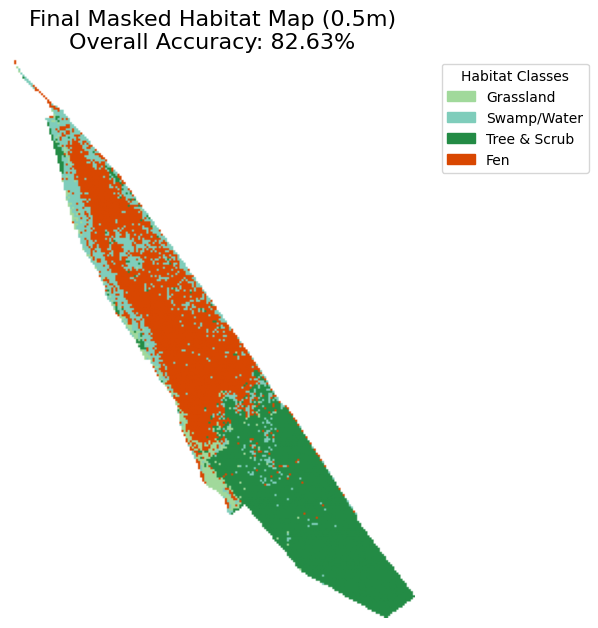

In [36]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import rasterio

# 1. Open and read the masked map
with rasterio.open(output_path) as src:
    # Read every 10th pixel for memory efficiency
    preview_data = src.read(1, out_shape=(src.height // 10, src.width // 10))

# 2. Define colors including index 0 as white/transparent
# Index 0: NoData (White)
# Index 1: Grassland (Light Green)
# Index 2: Swamp/Water (Cyan)
# Index 3: Tree & Scrub (Forest Green)
# Index 4: Fen (Red/Orange)
habitat_colors = ['#FFFFFF', '#A1D99B', '#7FCDBB', '#238B45', '#D94701']
cmap = ListedColormap(habitat_colors)

# 3. Create the figure
fig, ax = plt.subplots(figsize=(6, 8))
im = ax.imshow(preview_data, cmap=cmap, vmin=0, vmax=4)

# 4. Create Legend (excluding NoData)
legend_dict = {
    'Grassland': '#A1D99B',
    'Swamp/Water': '#7FCDBB',
    'Tree & Scrub': '#238B45',
    'Fen': '#D94701'
}
patches = [mpatches.Patch(color=color, label=label) for label, color in legend_dict.items()]

ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left',
          title="Habitat Classes", frameon=True)

plt.title(f"Final Masked Habitat Map (0.5m)\nOverall Accuracy: 82.63%", fontsize=16)
plt.axis('off') # Hides the x/y pixel coordinates for a cleaner look
plt.tight_layout()
plt.show()

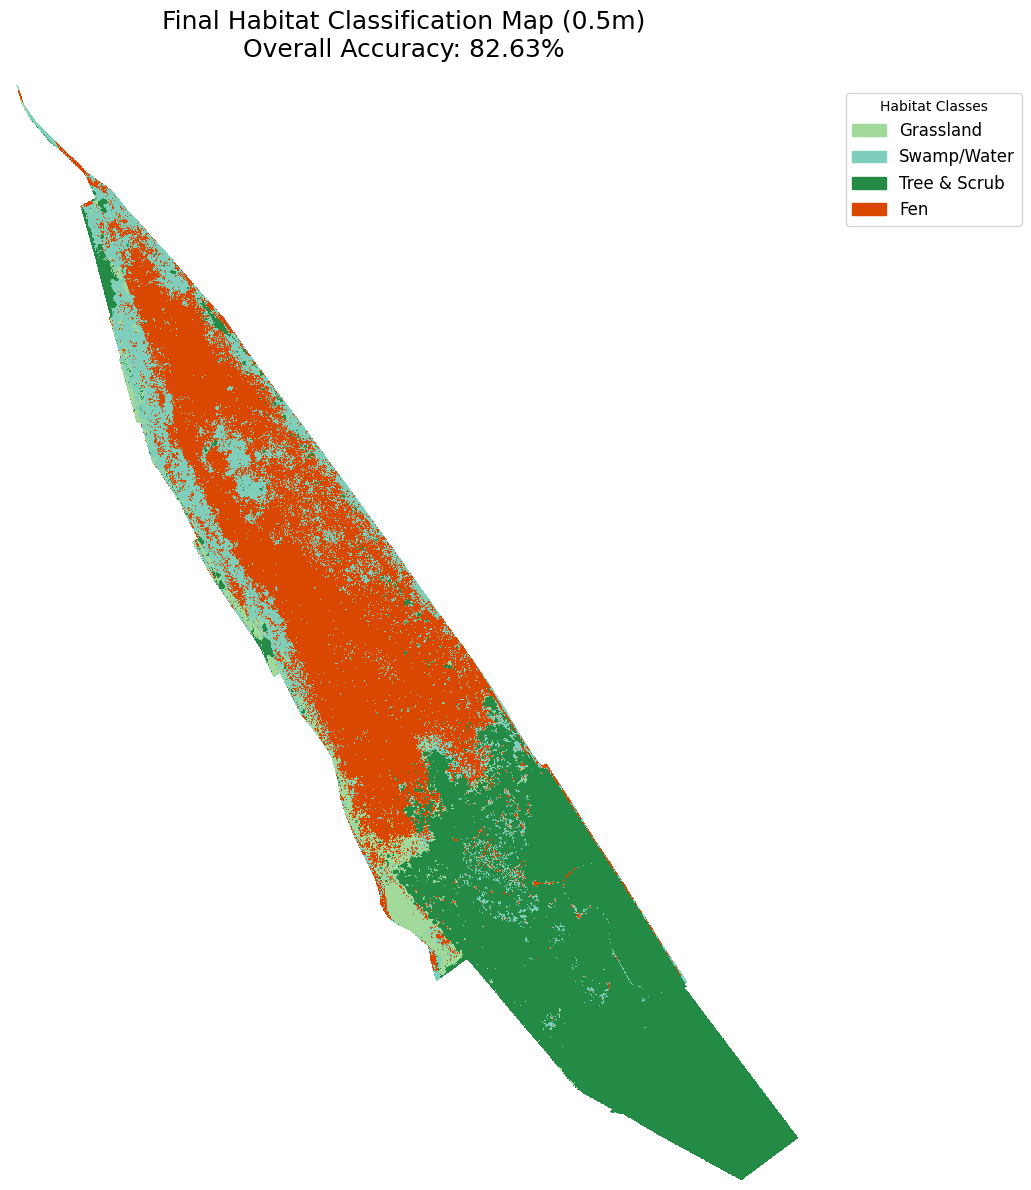

In [38]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import rasterio
import rasterio.plot  # <--- THIS IS THE MISSING PIECE
import numpy as np

# 1. Open the MASKED map file
with rasterio.open(output_path) as src:
    # Read the data
    map_data = src.read(1)
    # Now this will work!
    extent = rasterio.plot.plotting_extent(src)

# 2. Define the colors (0: Transparent, 1: Grassland, 2: Swamp, 3: Tree, 4: Fen)
habitat_colors = ['none', '#A1D99B', '#7FCDBB', '#238B45', '#D94701']
cmap = ListedColormap(habitat_colors)

# 3. Plotting
fig, ax = plt.subplots(figsize=(14, 12), facecolor='white')
ax.set_facecolor('white')

# vmin=0, vmax=4 ensures the color index matches your labels exactly
im = ax.imshow(map_data, cmap=cmap, extent=extent, vmin=0, vmax=4, interpolation='nearest')

# 4. Legend
legend_dict = {
    'Grassland': '#A1D99B',
    'Swamp/Water': '#7FCDBB',
    'Tree & Scrub': '#238B45',
    'Fen': '#D94701'
}
patches = [mpatches.Patch(color=color, label=label) for label, color in legend_dict.items()]

ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left',
          title="Habitat Classes", frameon=True, fontsize=12)

plt.title(f"Final Habitat Classification Map (0.5m)\nOverall Accuracy: 82.63%", fontsize=18, pad=20)
plt.axis('off')
plt.tight_layout()

# Save high-res image
plt.savefig("/content/drive/MyDrive/Final_Report_Map_Clean.png", dpi=300, bbox_inches='tight')
plt.show()

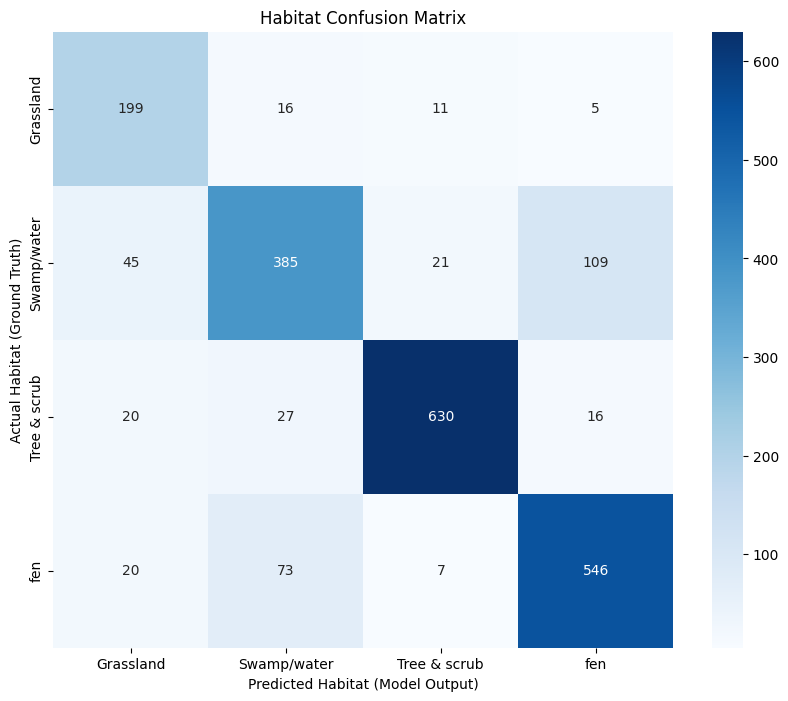

              precision    recall  f1-score   support

   Grassland       0.70      0.86      0.77       231
 Swamp/water       0.77      0.69      0.73       560
Tree & scrub       0.94      0.91      0.93       693
         fen       0.81      0.85      0.83       646

    accuracy                           0.83      2130
   macro avg       0.80      0.83      0.81      2130
weighted avg       0.83      0.83      0.83      2130



In [39]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# 1. Generate the matrix
cm = confusion_matrix(y_test, rf.predict(X_test), labels=unique_labels)

# 2. Plot as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=unique_labels, yticklabels=unique_labels, cmap='Blues')
plt.title('Habitat Confusion Matrix')
plt.ylabel('Actual Habitat (Ground Truth)')
plt.xlabel('Predicted Habitat (Model Output)')
plt.show()

# 3. Detailed Report (Precision, Recall, F1-Score)
print(classification_report(y_test, rf.predict(X_test)))

In [41]:
import numpy as np
import rasterio
from scipy.ndimage import generic_filter
from collections import Counter

# 1. Load the Masked Map
with rasterio.open(output_path) as src:
    map_data = src.read(1)
    meta = src.meta.copy()

# 2. Define the Majority Function
def mode_filter(window):
    # Flatten the 3x3 window and find the most common value
    # We ignore 0 (Background/NoData) so we don't 'shrink' the edges
    data = window[window > 0]
    if len(data) == 0:
        return 0
    counts = Counter(data)
    return counts.most_common(1)[0][0]

print("Applying 3x3 Majority Filter... this may take a moment.")
# 3. Run the filter
# size=3 creates the 3x3 window
smoothed_map = generic_filter(map_data, mode_filter, size=3)

# 4. Save the Smoothed Version
smooth_output_path = "/content/drive/MyDrive/Habitat_Map_0.5m_Smoothed.tif"
with rasterio.open(smooth_output_path, 'w', **meta) as dst:
    dst.write(smoothed_map.astype('uint8'), 1)

print(f"Smoothing complete! Saved to: {smooth_output_path}")

Applying 3x3 Majority Filter... this may take a moment.
Smoothing complete! Saved to: /content/drive/MyDrive/Habitat_Map_0.5m_Smoothed.tif


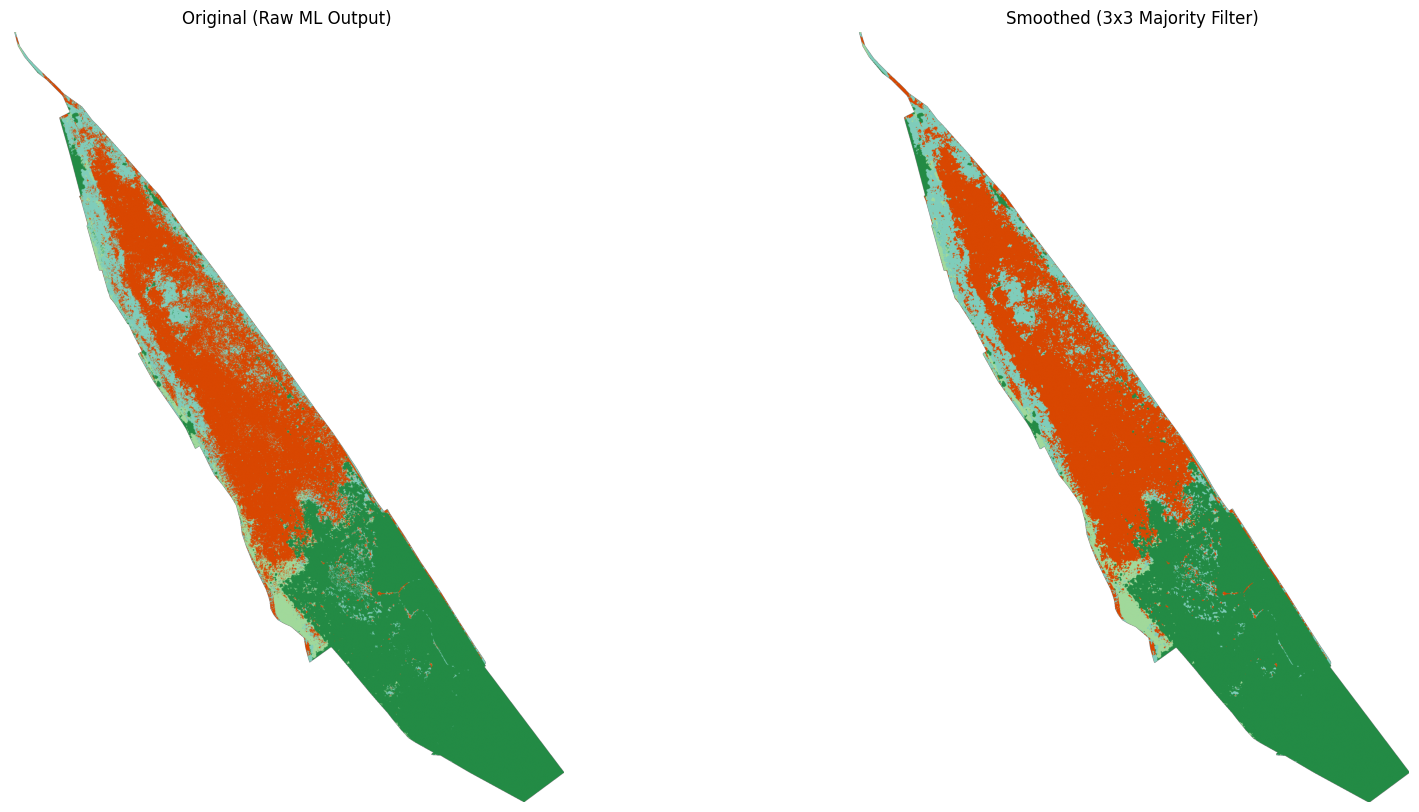

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Reuse the cmap from our previous plotting code
ax1.imshow(map_data, cmap=cmap, vmin=0, vmax=4)
ax1.set_title("Original (Raw ML Output)")
ax1.axis('off')

ax2.imshow(smoothed_map, cmap=cmap, vmin=0, vmax=4)
ax2.set_title("Smoothed (3x3 Majority Filter)")
ax2.axis('off')

plt.show()

In [43]:
import pandas as pd
import numpy as np
import rasterio

# 1. Load both datasets
with rasterio.open(output_path) as raw_src:
    raw_data = raw_src.read(1)
with rasterio.open(smooth_output_path) as smooth_src:
    smooth_data = smooth_src.read(1)

# 2. Calculation Constants (0.5m resolution)
pixel_size_ha = (target_res**2) / 10000
habitat_names = {v: k for k, v in label_to_int.items()}

# 3. Compile Statistics
stats = []
unique_vals = sorted([v for v in np.unique(raw_data) if v > 0])

for val in unique_vals:
    name = habitat_names.get(val, f"Class {val}")
    raw_count = np.sum(raw_data == val)
    smooth_count = np.sum(smooth_data == val)

    stats.append({
        "Habitat": name,
        "Raw Area (Ha)": round(raw_count * pixel_size_ha, 4),
        "Smoothed Area (Ha)": round(smooth_count * pixel_size_ha, 4),
        "Change (Ha)": round((smooth_count - raw_count) * pixel_size_ha, 4)
    })

df_comparison = pd.DataFrame(stats)

print("--- FINAL HABITAT AREA COMPARISON ---")
print(df_comparison.to_string(index=False))

# Save the final table to Drive
df_comparison.to_csv("/content/drive/MyDrive/Final_Habitat_Statistics.csv", index=False)

--- FINAL HABITAT AREA COMPARISON ---
     Habitat  Raw Area (Ha)  Smoothed Area (Ha)  Change (Ha)
   Grassland         1.0729              1.0471      -0.0258
 Swamp/water         4.1043              3.9646      -0.1397
Tree & scrub        11.1500             11.3105       0.1604
         fen        10.5500             10.7952       0.2452
